# Impots

In [1]:
from __future__ import print_function, absolute_import, division

# general imports for deep learning
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# data read
import pandas as pd

# plot
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

#tensorboard: currently some error
#!pip install -U tensorboardcolab
#from tensorboardcolab import *

# json and pretty print
import json
import pprint

# to persist the numpy arrays data
import h5py

# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):\
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])

def plot_prediction(original, predicted):
    #fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    # Get subplots
    f, (plt1, plt2, plt3) = plt.subplots(3)
    # Get Daily errors
    
    a = original
    b = predicted
    if(len(original.shape) > 1):
        a = original.reshape(original.shape[0]*original.shape[1])
    if(len(predicted.shape) > 1):
        b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
    daily_errors = abs(a - b)
    t = 7
    weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
    # Calculate R2 metric
  
    # FROM wikipedia: 
    # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
    # This would occur when the wrong model was chosen.
    m = np.mean(a)
    ss_tot = np.sum(np.power((a - m), 2))
    ss_res = np.sum(np.power((a - b), 2))
    r_square = 1 - (ss_res / ss_tot)
    r_square = "{0:.4f}".format(r_square)
    mape = calc_mape(b, a)
  
    # Get weekly errors
    # plot original vs predicted  
    plt1.plot(original, color='black', label = 'Original data') 
    plt1.plot(predicted, color='blue', label = 'Predicted data')

    # PLOT DAILY ERRORS
    plt2.plot(daily_errors, color='red')
    
    # PLOT WEEKLY ERRORS
    for i, e in enumerate(weekly_errors):
        plt3.bar(x=i*7, height=e, width=5, color='red')

    plt1.set_title('Actual and Predicted - R2: '+str(r_square) + ' - MAPE:'+str(mape))  
    plt2.set_title('Daily Errors')
    plt3.set_title('Weekly Errors')
  
    # IF YOU ARE USING COLAB, USE THIS:
    plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
    # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
    # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
    
    plt.show()

def plot_prediction1(original, predicted):
  plt.style.use('seaborn-darkgrid')
  
  # Get subplots
  f, (plt1, plt2, plt3) = plt.subplots(3)
  
  # Get Daily errors
  a = original
  b = predicted
  if(len(original.shape) > 1):
    a = original.reshape(original.shape[0]*original.shape[1])
    
  if(len(predicted.shape) > 1):
    b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
  daily_errors = abs(a - b)
  
  t = 7
  weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
  # Calculate R2 metric
  
  # FROM wikipedia: 
  # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
  # This would occur when the wrong model was chosen.
  m = np.mean(a)
  ss_tot = np.sum(np.power((a - m), 2))
  ss_res = np.sum(np.power((a - b), 2))
  r_square = 1 - (ss_res / ss_tot)
  r_square = "{0:.4f}".format(r_square)
  
  # Get weekly errors
  # plot original vs predicted  
  plt1.plot(original, 
           color='black', 
           label = 'Original data') 
  plt1.plot(predicted,
           color='blue', 
           label = 'Predicted data')



  # PLOT DAILY ERRORS
  plt2.plot(daily_errors, color='red')

    
  # PLOT WEEKLY ERRORS
  for i, e in enumerate(weekly_errors):
    plt3.bar(x=i*7, height=e, width=5, color='red')

  plt1.set_title('Actual and Predicted - R2: '+str(r_square))  
  plt2.set_title('Daily Errors')
  plt3.set_title('Weekly Errors')
  
  # IF YOU ARE USING COLAB, USE THIS:
  plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
  # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
  # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
  
  plt.show()

# Get data

In [2]:
save_filename = 'models/'
monthly_data_name = 'data/monthly_crude_oil_83_19.csv'
weekly_data_name ='data/weekly_crude_oil_83_19.csv'
column_names = ['Date','Price',	'Open',	'High', 'Low',	'Vol.',	'Change %']

In [3]:
weekly_data = pd.read_csv(weekly_data_name)
monthly_data = pd.read_csv(monthly_data_name)

In [4]:
def getVolumeAsFloat(_lst):
  l = len(_lst)
  result = np.zeros(l)
  for i in range(l):
    vol = _lst[i]
    if 'M' in vol:
      _id = vol.index('M')
      _mlt = 1000000
    elif 'K' in vol:
      _id = vol.index('K')
      _mlt = 1000
    else:
      _id = -1

    result[i] = float(vol[:_id]) * _mlt
  return result

In [5]:
# returns normalized dataset between a and b
def minmax_norm(dataset, a, b):
  # NORMALIZE DATASET
  d = dataset
  mi = np.min(dataset)
  ma = np.max(dataset)

  norm_dataset = ((b-a) * ((d - mi)/(ma - mi))) + a
  return norm_dataset

def minmax_denorm(old_data, val, a=-1, b=1):
  mi = min(old_data)
  ma = max(old_data)

  return ((val - a) * (ma-mi) / (b-a)) + mi


def get_test(X, percentage=0.9):
    iXPercentage = int(len(X) * percentage) 
    X_train_val = X[0:iXPercentage]
    X_test = X[iXPercentage:]
    return X_train_val, X_test

In [6]:
def get_data_chunks(d_list, windows, quantity=False):
  length = len(d_list[0])
  step = 1
  forecast = 1
  
  data_dict = {}
  for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
      try:
        # Get windowed data
        windowed_features_list = []
        for j in range(len(d_list)):
          windowed_features_list.append(d_list[j][i:i+window])

        # ALWAYS TAKE THE FIRST data 
        if quantity:
          y_i = d_list[1][i + window + forecast - 1] # get volume important.
        else:
          y_i = d_list[0][i + window + forecast - 1] # get price
        x_i = np.column_stack(tuple(windowed_features_list))
      except Exception as e:
        print(e)
        break

      X.append(x_i)
      Y.append(y_i)
    data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}
    
  return data_dict

# Weekly

In [7]:
weekly_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"May 26, 2019",59.17,58.94,59.34,58.14,-,0.92%
1,"May 19, 2019",58.63,62.93,63.81,57.33,2.79M,-6.58%
2,"May 12, 2019",62.76,61.65,63.64,60.64,3.24M,1.78%
3,"May 05, 2019",61.66,61.43,62.95,60.04,3.96M,-0.45%
4,"Apr 28, 2019",61.94,62.95,64.75,60.95,3.64M,-2.15%


In [8]:
weekly_prices = np.array(weekly_data[column_names[1]])[1:]
weekly_volumes = np.array(weekly_data[column_names[5]])[1:]
weekly_volumes = getVolumeAsFloat(weekly_volumes)

weekly_prices = np.flip(weekly_prices)
weekly_volumes = np.flip(weekly_volumes)

In [9]:
# Extract Test
weekly_prices, test_weekly_prices = get_test(weekly_prices)
weekly_volumes, test_weekly_volumes = get_test(weekly_volumes)

In [10]:
norm_weekly_prices = minmax_norm(weekly_prices, a=-1, b=1)
norm_weekly_volumes = minmax_norm(weekly_volumes, a=-1, b=1)

In [11]:
#normalized d_list
d_list = [norm_weekly_prices, norm_weekly_volumes]
windows = [6,8,12]
data_dict = get_data_chunks(d_list, windows)

index 1697 is out of bounds for axis 0 with size 1697
index 1697 is out of bounds for axis 0 with size 1697
index 1697 is out of bounds for axis 0 with size 1697


In [12]:
  def build_bidir_lstm_model(tensor_shape):
    # L2 norm regularizer
    regularizer = tf.keras.regularizers.l2(0.01)

    # XAVIER INITIALIZER
#    initializer = tf.keras.initializers.glorot_uniform()

    model = tf.keras.Sequential()

  # hyperbolic tangent is automatically seleceted as activation function
    units = tensor_shape[0]
    model.add(layers.Bidirectional(layers.LSTM(units, return_sequences=True), batch_input_shape=(None, tensor_shape[0], tensor_shape[1])))
    #model.add(layers.LSTM(units, 
                          #batch_input_shape=(None, tensor_shape[0], tensor_shape[1]),
                          #recurrent_regularizer=regularizer,
                          #bias_regularizer=regularizer, 
                          #kernel_regularizer=regularizer
                         #))


    #model.add(layers.LSTM(units, return_sequences=True))
    #model.add(layers.LSTM(units))
    
    model.add(layers.Dense(32,activation='relu'))
    model.add(layers.Dense(32,activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [13]:
w = 6
b = 64

In [14]:
model = build_bidir_lstm_model(tensor_shape=(w, 2))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 6, 12)             432       
_________________________________________________________________
dense (Dense)                (None, 6, 32)             416       
_________________________________________________________________
dense_1 (Dense)              (None, 6, 32)             1056      
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 193       
Total params: 2,097
Trainable params: 2,097
Non-trainable params: 0
_________________________________________________________________


In [16]:
print('save_filename: '+save_filename)
learning_rate=0.001
epochs=10000
verbose=1
save_filename = 'models/'
model_save_name = save_filename + 'crude_oil_weekly_bidirlstm_model_w6_b64'
    
opt_1 = tf.keras.optimizers.Adam(learning_rate)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: "+model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    
callbacks.append(cp)
callbacks.append(early_stop)    

save_filename: models/
Model will be saved at: models/crude_oil_weekly_bidirlstm_model_w6_b64


In [17]:
  def get_train_validation(X, y, percentage=0.8):
    iXPercentage = int(len(X) * percentage) 
    iYPercentage = int(len(y) * percentage)
    X_train = X[0:iXPercentage]
    Y_train = y[0:iYPercentage]
    
    #X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_val = X[iXPercentage:]
    Y_val = y[iYPercentage:]
    return X_train, X_val, Y_train, Y_val

In [18]:
nX = data_dict[w]['X']
nY =data_dict[w]['Y']
X_train, X_val, Y_train, Y_val = get_train_validation(nX, nY)

In [19]:
print('X_train: '+str(X_train.shape))
print('X_val: '+str(X_val.shape))
#print('X_test: '+str(X_test.shape))

X_train: (1352, 6, 2)
X_val: (339, 6, 2)


In [20]:
print(X_train[0])
print(Y_train[0])
print('*'*100)
print(X_train[1])
print(Y_train[1])
print('*'*100)

[[-0.70869888 -0.9989643 ]
 [-0.7072119  -0.99897724]
 [-0.70319703 -0.99952099]
 [-0.70498141 -0.99947568]
 [-0.71256506 -0.99952746]
 [-0.71732342 -0.99962456]]
-0.7098884758364312
****************************************************************************************************
[[-0.7072119  -0.99897724]
 [-0.70319703 -0.99952099]
 [-0.70498141 -0.99947568]
 [-0.71256506 -0.99952746]
 [-0.71732342 -0.99962456]
 [-0.70988848 -0.999398  ]]
-0.7115241635687732
****************************************************************************************************


In [21]:
history = model.fit(X_train, Y_train, 
                    epochs = epochs,  batch_size = b, 
                    verbose=verbose, validation_data=(X_val, Y_val), validation_split=0.8, callbacks=callbacks)

Train on 1352 samples, validate on 339 samples
Epoch 1/10000
1216/1352 [=========================>....] - ETA: 0s - loss: 0.6353 - mean_absolute_error: 0.7543 - mean_squared_error: 0.6353 - mean_absolute_percentage_error: 104.2708
Epoch 00001: val_loss improved from inf to 0.06881, saving model to models/crude_oil_weekly_bidirlstm_model_w6_b64
1352/1352 [==============================] - 5s 4ms/step - loss: 0.6126 - mean_absolute_error: 0.7400 - mean_squared_error: 0.6126 - mean_absolute_percentage_error: 101.7731 - val_loss: 0.0688 - val_mean_absolute_error: 0.2288 - val_mean_squared_error: 0.0688 - val_mean_absolute_percentage_error: 266.6147
Epoch 2/10000
1280/1352 [===========================>..] - ETA: 0s - loss: 0.1959 - mean_absolute_error: 0.4025 - mean_squared_error: 0.1959 - mean_absolute_percentage_error: 59.9515 ETA: 0s - loss: 0.2503 - mean_absolute_error: 0.4669 - mean_squared_error: 0.2503 - mean_absolute_percentage_error: 6
Epoch 00002: val_loss did not improve from 0.0

Epoch 30/10000
1216/1352 [=========================>....] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0244 - mean_squared_error: 0.0018 - mean_absolute_percentage_error: 13.8839
Epoch 00030: val_loss improved from 0.00812 to 0.00804, saving model to models/crude_oil_weekly_bidirlstm_model_w6_b64
1352/1352 [==============================] - 1s 423us/step - loss: 0.0018 - mean_absolute_error: 0.0247 - mean_squared_error: 0.0018 - mean_absolute_percentage_error: 13.2841 - val_loss: 0.0080 - val_mean_absolute_error: 0.0705 - val_mean_squared_error: 0.0080 - val_mean_absolute_percentage_error: 157.4338
Epoch 31/10000
1216/1352 [=========================>....] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0257 - mean_squared_error: 0.0019 - mean_absolute_percentage_error: 8.2523
Epoch 00031: val_loss improved from 0.00804 to 0.00803, saving model to models/crude_oil_weekly_bidirlstm_model_w6_b64
1352/1352 [==============================] - 1s 433us/step - loss: 0.0019 - mean_absolu

Epoch 45/10000
1344/1352 [============================>.] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0228 - mean_squared_error: 0.0013 - mean_absolute_percentage_error: 10.9914
Epoch 00045: val_loss improved from 0.00744 to 0.00731, saving model to models/crude_oil_weekly_bidirlstm_model_w6_b64
1352/1352 [==============================] - 1s 454us/step - loss: 0.0013 - mean_absolute_error: 0.0230 - mean_squared_error: 0.0013 - mean_absolute_percentage_error: 11.2243 - val_loss: 0.0073 - val_mean_absolute_error: 0.0674 - val_mean_squared_error: 0.0073 - val_mean_absolute_percentage_error: 187.8391
Epoch 46/10000
1344/1352 [============================>.] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0222 - mean_squared_error: 0.0013 - mean_absolute_percentage_error: 10.9795
Epoch 00046: val_loss did not improve from 0.00731
1352/1352 [==============================] - 1s 453us/step - loss: 0.0013 - mean_absolute_error: 0.0222 - mean_squared_error: 0.0013 - mean_absolute_perce

Epoch 60/10000
1216/1352 [=========================>....] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0203 - mean_squared_error: 0.0010 - mean_absolute_percentage_error: 9.6700 
Epoch 00060: val_loss did not improve from 0.00670
1352/1352 [==============================] - 1s 396us/step - loss: 0.0010 - mean_absolute_error: 0.0202 - mean_squared_error: 0.0010 - mean_absolute_percentage_error: 9.4143 - val_loss: 0.0070 - val_mean_absolute_error: 0.0649 - val_mean_squared_error: 0.0070 - val_mean_absolute_percentage_error: 218.7763
Epoch 61/10000
1344/1352 [============================>.] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0010 - mean_absolute_percentage_error: 10.0740
Epoch 00061: val_loss did not improve from 0.00670
1352/1352 [==============================] - 1s 421us/step - loss: 0.0010 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0010 - mean_absolute_percentage_error: 10.0302 - val_loss: 0.0068 - val_mean_absolute_error: 0.

Epoch 75/10000
1280/1352 [===========================>..] - ETA: 0s - loss: 9.6274e-04 - mean_absolute_error: 0.0202 - mean_squared_error: 9.6274e-04 - mean_absolute_percentage_error: 9.2935
Epoch 00075: val_loss did not improve from 0.00558
1352/1352 [==============================] - 1s 431us/step - loss: 9.7342e-04 - mean_absolute_error: 0.0202 - mean_squared_error: 9.7342e-04 - mean_absolute_percentage_error: 9.0420 - val_loss: 0.0058 - val_mean_absolute_error: 0.0597 - val_mean_squared_error: 0.0058 - val_mean_absolute_percentage_error: 251.9066
Epoch 76/10000
1344/1352 [============================>.] - ETA: 0s - loss: 9.4744e-04 - mean_absolute_error: 0.0198 - mean_squared_error: 9.4744e-04 - mean_absolute_percentage_error: 9.0862
Epoch 00076: val_loss did not improve from 0.00558
1352/1352 [==============================] - 1s 421us/step - loss: 9.4312e-04 - mean_absolute_error: 0.0198 - mean_squared_error: 9.4312e-04 - mean_absolute_percentage_error: 9.0638 - val_loss: 0.0059 

Epoch 90/10000
1280/1352 [===========================>..] - ETA: 0s - loss: 9.6825e-04 - mean_absolute_error: 0.0204 - mean_squared_error: 9.6825e-04 - mean_absolute_percentage_error: 9.0771
Epoch 00090: val_loss did not improve from 0.00558
1352/1352 [==============================] - 1s 445us/step - loss: 9.3860e-04 - mean_absolute_error: 0.0201 - mean_squared_error: 9.3860e-04 - mean_absolute_percentage_error: 8.8012 - val_loss: 0.0059 - val_mean_absolute_error: 0.0590 - val_mean_squared_error: 0.0059 - val_mean_absolute_percentage_error: 257.0816


In [22]:
model.evaluate(X_val, Y_val)

339/339 [==============================] - 0s 1ms/step


[0.005881926608010906,
 0.059045757823637454,
 0.005881926608010906,
 257.0816363106787]

In [23]:
i = 0
t = X_val[i].reshape(1, X_val[i].shape[0], X_val[i].shape[1])
model.predict(t)

array([[-0.3638027]], dtype=float32)

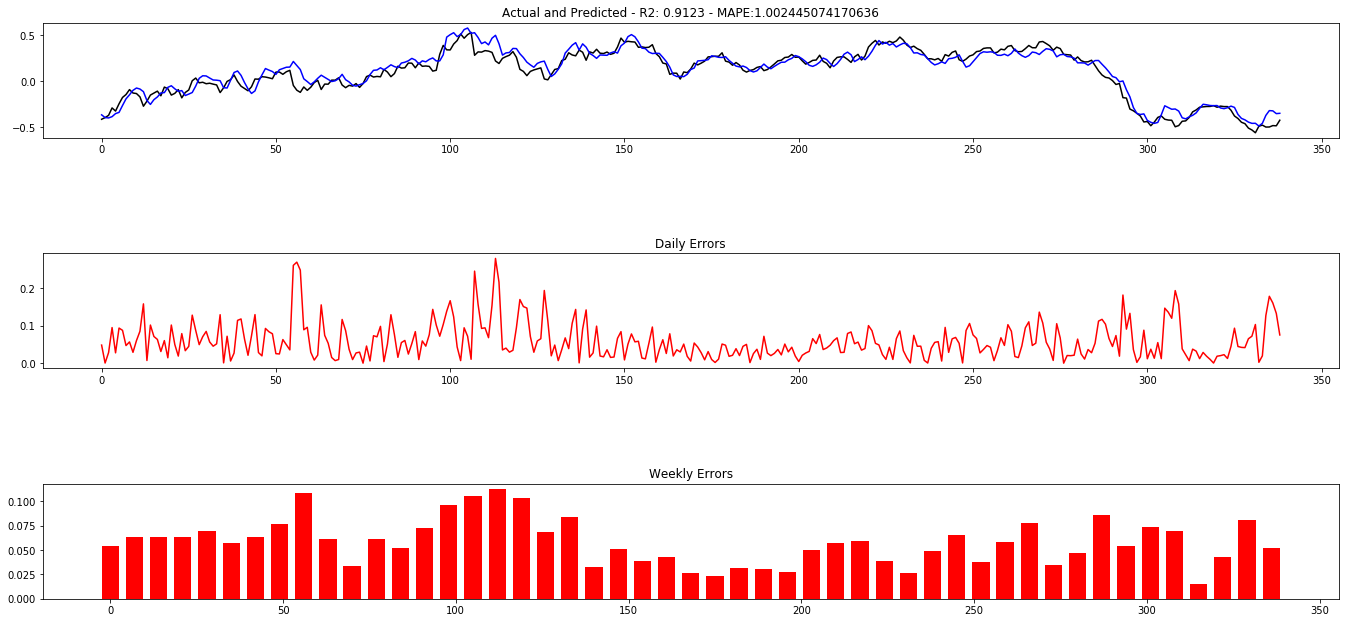

In [24]:
plot_prediction(Y_val, model.predict(X_val))

## Test

In [25]:
norm_test_weekly_prices = minmax_norm(test_weekly_prices, a=-1, b=1)
norm_test_weekly_volumes = minmax_norm(test_weekly_volumes, a=-1, b=1)

### NOT normalized

In [26]:
#normalized d_list
d_list = [test_weekly_prices, test_weekly_volumes]
windows = [6,8,12]
test_data_dict = get_data_chunks(d_list, windows)

index 189 is out of bounds for axis 0 with size 189
index 189 is out of bounds for axis 0 with size 189
index 189 is out of bounds for axis 0 with size 189


### Normalized

In [27]:
#normalized d_list
d_list = [norm_test_weekly_prices, norm_test_weekly_volumes]
windows = [6,8,12]
norm_test_data_dict = get_data_chunks(d_list, windows)

index 189 is out of bounds for axis 0 with size 189
index 189 is out of bounds for axis 0 with size 189
index 189 is out of bounds for axis 0 with size 189


### result

In [28]:
X_test = norm_test_data_dict[w]['X']
#Y_test = test_data_dict[w]['Y']
not_norm_true_values = test_data_dict[w]['Y']

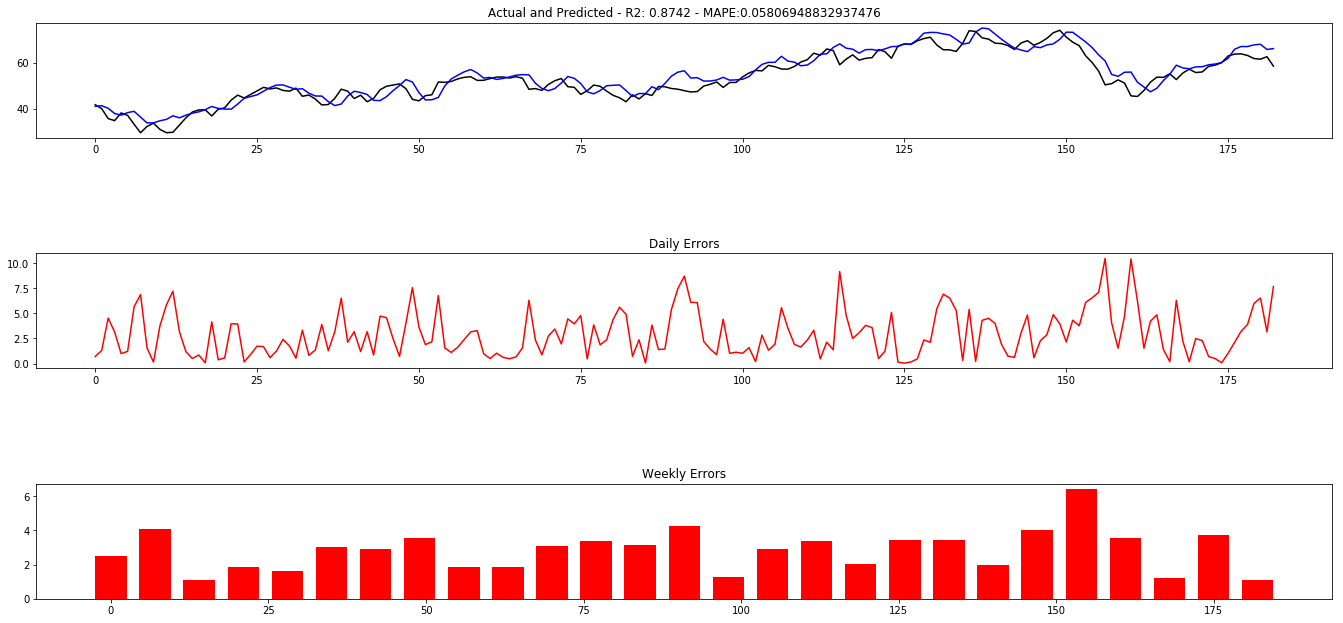

In [29]:
pred_y = model.predict(X_test)
pred_yy = minmax_denorm(test_weekly_prices, pred_y, a=-1, b=1)
plot_prediction(not_norm_true_values, pred_yy)